In [1]:
import raw_data
import ta

import math
import time
import datetime
from pytz import timezone

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

pd.set_option("display.max_columns", 60)
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
prediction_period = 1  # Predict 1 day into the future
saved_models_root = "saved_models/"

daily_adjusted_df = raw_data.get_time_series_daily_adjusted("amzn")
EST = timezone("US/Eastern")
datetime_last_updated = datetime.datetime.now(EST)
print("Data retrieved on", datetime_last_updated.ctime())

# Remove most recent day if markets hadn't closed yet
latest_date = datetime.datetime.strptime(daily_adjusted_df.loc[0, "timestamp"], "%Y-%m-%d").date()
if latest_date == datetime_last_updated.date():
    closing_time = datetime.time(16, tzinfo=EST)
    if datetime_last_updated.timetz() < closing_time:
        daily_adjusted_df = daily_adjusted_df.iloc[1:].reset_index()

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

Data retrieved on Thu Sep  6 16:02:04 2018


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5364.000000,5364.000000,5364.000000,5364.000000,5364.000000,5.364000e+03,5364.0,5364.000000
mean,240.724858,243.618359,237.601025,240.765602,233.259375,6.498816e+06,0.0,1.000746
std,349.628131,352.299262,346.304072,349.537170,352.922118,5.437452e+06,0.0,0.033440
min,5.910000,6.100000,5.510000,5.970000,1.395800,4.060000e+04,0.0,1.000000
25%,40.357500,41.250000,39.707500,40.380000,36.092500,3.477399e+06,0.0,1.000000
50%,86.410000,88.530000,84.410000,86.445000,74.935000,5.433210e+06,0.0,1.000000
75%,271.552500,275.864925,269.427500,273.380000,270.512500,7.951100e+06,0.0,1.000000
max,2038.110000,2050.500000,2013.000000,2039.510000,2039.510000,1.043292e+08,0.0,3.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-09-06,2006.505,2007.50,1935.37,1958.31,1958.31,7244045,0.0,1.0
1,2018-09-05,2038.110,2040.38,1989.89,1994.82,1994.82,8220576,0.0,1.0
2,2018-09-04,2026.500,2050.50,2013.00,2039.51,2039.51,5721093,0.0,1.0
3,2018-08-31,2007.000,2022.38,2004.74,2012.71,2012.71,4204378,0.0,1.0
4,2018-08-30,1997.420,2025.57,1986.90,2002.38,2002.38,7277257,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, selected_features=None):
    base_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days, since we don't have their target values
    processed_df = base_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    
    if selected_features is None:
        # Drop features with very low variance
        original_num_features = processed_df.shape[1]
        processed_df = processed_df.loc[:, processed_df.std() > 0.01]
        print("Dropped {} features.".format(original_num_features - processed_df.shape[1]))
    else:
        processed_df = processed_df.loc[:, selected_features]
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df

In [4]:
def preprocess_features(df, means=None, stds=None):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()

    # Normalize features
    calculated_stats = False
    if means is None:
        means = processed_features.mean()
        calculated_stats = True
    if stds is None:
        stds = processed_features.std()
        calculated_stats = True
    processed_features = (processed_features - means) / stds
    
    if calculated_stats:
        return processed_features, means, stds
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

Dropped 2 features.


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5363.000000,5363.000000,5363.000000,5363.000000,5.363000e+03,5.363000e+03,5.363000e+03,5.363000e+03,5363.000000,5.363000e+03,5.363000e+03,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000
mean,240.395606,243.289460,237.284454,232.937717,6.498677e+06,-1.317551e+07,-7.814342e+03,-7.386093e+03,-2.335701,1.815013e+06,1.743191e+03,212.384379,14.617989,251.669755,220.934387,236.302071,0.040462,0.071042,239.445071,245.467348,233.422795,0.108148,249.136993,223.450431,0.095655,0.161290,-4.826025,-4.830128,0.004103,237.291795,242.117820,32.562951,16.113015,19.352859,0.408354,0.713826,0.767221,0.205579,-0.129267,24.896435,-15.195377,0.507175,-14.740626,-14.614204,-0.126422,251.738127,258.639569,46.013713,49.789906,-7.589525,44.908315,17.604499,17.636746,-82.395501,-4.962742,-0.058678,-0.129148,-88.322870,0.200314
std,348.828071,351.507557,345.559274,352.167812,5.437949e+06,5.360891e+07,8.456715e+06,2.409831e+06,7.964886,6.382388e+07,6.055114e+05,264.542383,25.018228,377.171218,340.640421,358.718808,0.197060,0.256919,352.767405,358.719631,346.864326,0.310597,373.973119,343.713748,0.294146,0.367833,12.482980,12.047316,3.101749,360.746193,369.176711,10.013531,8.751718,9.833603,0.491575,0.257137,0.260141,0.157934,0.563438,1.149886,87.450243,9.026338,134.546016,131.478364,43.042878,369.299695,379.742527,11.823260,13.400876,15.204053,16.559572,103.632340,102.431745,103.632340,21.777497,3.741827,3.763509,17.654115,3.820059
min,5.910000,6.100000,5.510000,1.395800,4.060000e+04,-5.795261e+08,-1.043292e+08,-1.272262e+07,-48.756969,-1.015144e+09,-1.417302e+07,0.043194,0.805838,1.657439,1.054363,1.531875,0.000000,0.000000,6.587667,7.378333,5.784667,0.000000,1.687500,1.395800,0.000000,0.000000,-81.794826,-74.990637,-18.205707,1.583921,1.844874,10.722179,0.000000,0.209474,0.000000,0.029056,0.032817,0.000000,-2.778932,19.780102,-254.272762,-107.454500,-547.177024,-529.579589,-234.060690,7.210000,7.750000,15.875302,9.223969,-47.107398,-4.237057,-923.811429,-847.172143,-1023.811429,-141.560941,-25.634726,-29.618110,-99.930029,-24.766064
25%,40.355000,41.250000,39.705000,36.085000,3.476622e+06,-4.957312e+06,-5.347900e+06,-1.199293e+06,-0.092998,-2.197587e+06,-1.017170e+05,14.424463,1.878694,40.483831,32.682079,36.378750,0.000000,0.000000,39.408908,40.991513,37.904667,0.000000,39.750000,33.830000,0.000000,0.000000,-5.544729,-5.447286,-0.790958,36.553638,36.895535,25.041836,9.767433,12.529441,0.000000,0.627797,0.703329,0.068563,-0.401265,24.245883,-83.533048,-1.649500,-82.286007,-81.857964,-21.255427,41.283750,41.975000,37.478608,40.550269,-19.680014,44.883716,12.920918,15.425130,-87.079082,-8.203848,-1.537627,-1.549571,-98.191065,-1.370099
50%,86.41

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,2038.11,2040.38,1989.89,1994.82,8220576,0.000000e+00,0,0.0,0.0,0.00,0.000000,1000.000000,50.490000,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,0.000000,0.000000,0.000000,1994.820000,1994.820000,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,50.000000,50.0,0.000000,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0.000000,-1.830240
2,2026.50,2050.50,2013.00,2039.51,5721093,-4.247441e+06,5721093,0.0,0.0,0.00,0.000000,1022.403024,53.174483,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,0.472196,0.248524,0.223672,2018.058800,2017.586604,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,2.240302,2.215576,2.240302,-2.191213
3,2007.00,2022.38,2004.74,2012.71,4204378,1.962586e+06,-4204378,0.0,0.0,-71849782.22,72922.527158,1008.968228,46.611870,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,0.232057,0.242448,-0.010391,2016.131407,2015.899350,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,60.882004,50.0,64.543416,50.0,50.0,50.0,-50.0,0.0,-1.314041,-1.322751,0.896823,1.331538
4,1997.42,2025.57,1986.90,2002.38,7277257,-1.856119e+06,-7277257,0.0,0.0,-57780369.32,-92596.930883,1008.968228,44.416456,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,-0.055372,0.155847,-0.211219,2012.270469,2012.325841,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,52.414477,50.0,48.784253,50.0,50.0,50.0,-50.0,0.0,-0.513238,-0.514560,0.378982,0.515886
5,1953.45,1998.69,1948.94,1998.10,6531761,4.925902e+06,-6531761,0.0,0.0,-34003065.63,-51311.029747,1006.811602,46.478360,2030.667016,1821.321984,1925.9945,0.0,0.0,1961.034333,1989.714333,1932.354333,0.0,2039.51,1876.71,0.0,0.0,-0.296413,0.045408,-0.341821,2008.965558,2009.261970,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1860.9275,1848.405,49.366533,50.0,39.892928,50.0,50.0,50.0,-50.0,0.0,-0.213746,-0.213974,0.164426,0.214203


In [6]:
# Use 85% for training, 10% for validation, and most recent 5% for testing
num_rows = len(df)
num_training = int(num_rows * 0.85)
num_validation = int(num_rows * 0.1)
num_testing = num_rows - num_training - num_validation

# Shuffle before splitting into training and validation sets
training_and_validation_df = df.tail(num_training + num_validation).sample(frac=1)

training_df = training_and_validation_df.head(num_training)
training_examples, feature_means, feature_stds = preprocess_features(training_df)
training_targets = preprocess_targets(training_df)

validation_df = training_and_validation_df.tail(num_validation)
validation_examples = preprocess_features(validation_df, feature_means, feature_stds)
validation_targets = preprocess_targets(validation_df)

testing_df = df.head(num_testing)
testing_examples = preprocess_features(testing_df, feature_means, feature_stds)
testing_targets = preprocess_targets(testing_df)

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Testing examples summary:")
display.display(testing_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Testing targets summary:")
display.display(testing_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03,4.558000e+03
mean,-2.389781e-15,-3.569861e-16,-4.455312e-15,1.311028e-15,-4.676674e-18,-1.083430e-16,-2.338337e-17,-1.558891e-18,-1.590069e-16,1.948614e-17,2.026559e-17,-5.549654e-16,-1.156697e-15,6.859123e-16,2.637644e-15,-1.537067e-15,3.195728e-17,-9.197460e-17,5.892610e-16,-1.914319e-15,-4.131062e-16,-3.897229e-17,3.053868e-15,3.747575e-15,3.195728e-17,1.091224e-17,-1.258025e-15,3.055427e-16,7.794457e-18,2.279099e-15,6.687644e-16,5.453002e-15,-3.367206e-15,-5.196175e-15,1.605658e-16,3.923730e-15,-1.741282e-15,-1.441195e-15,4.739030e-16,-6.815785e-14,-1.636836e-16,-7.716513e-17,3.413972e-16,-9.976905e-17,1.558891e-17,1.342206e-15,-1.861316e-15,-7.064896e-15,-7.392263e-15,7.170901e-17,4.411663e-16,-1.184758e-16,-2.525404e-16,1.340647e-16,1.021074e-16,1.870670e-17,6.859123e-17,-5.668129e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.857588e-01,-7.904283e-01,-7.826842e-01,-7.606718e-01,-1.193148e+00,-1.038605e+01,-1.214901e+01,-5.221783e+00,-5.725128e+00,-1.324255e+01,-2.237610e+01,-7.883050e-01,-5.063944e-01,-7.766673e-01,-7.418729e-01,-7.598641e-01,-2.142021e-01,-2.747558e-01,-7.686682e-01,-7.757335e-01,-7.613069e-01,-3.525541e-01,-7.752164e-01,-7.453173e-01,-3.341898e-01,-4.287840e-01,-4.317998e+00,-4.600057e+00,-5.856437e+00,-7.599848e-01,-7.585297e-01,-2.184344e+00,-1.844711e+00,-1.935192e+00,-8.572618e-01,-2.650155e+00,-2.790423e+00,-1.310564e+00,-4.653511e+00,-4.120716e+00,-2.727419e+00,-9.361916e+00,-3.879482e+00,-3.865590e+00,-5.342934e+00,-7.795783e-01,-7.783239e-01,-2.620625e+00,-3.082334e+00,-2.746152e+00,-2.931732e+00,-8.879021e+00,-7.973248e+00,-8.879021e+00,-5.492535e+00,-6.660374e+00,-7.635376e+00,-7.606718e-01
25%,-6.357651e-01,-6.382703e-01,-6.324943e-01,-6.088645e-01,-5.500570e-01,1.521141e-01,-6.386648e

Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,-0.011593,-0.010806,-0.012231,-0.023195,0.003248,-0.078418,0.047486,-0.002567,-0.062471,-0.049605,0.028488,0.009599,0.117172,-0.021395,-0.020258,-0.020868,-0.068481,-0.004604,-0.014618,-0.013295,-0.015978,0.099529,-0.023170,-0.021387,-0.048763,-0.001327,-0.008249,0.005958,-0.042666,-0.021281,-0.020660,0.053682,-0.054716,-0.021792,0.014811,-0.097171,-0.069966,-0.049394,-0.014247,0.013182,-0.027558,0.080289,-0.008240,0.007773,-0.049249,-0.005786,-0.007133,-0.034106,-0.004558,0.003268,-0.079799,-0.055542,-0.054914,-0.055542,-0.048061,0.036597,0.038106,-0.023195
std,0.924578,0.925115,0.922745,0.931217,1.045866,1.065452,1.019453,1.017304,1.064575,0.678512,0.786220,0.982289,1.202041,0.928004,0.934565,0.931110,0.831516,0.993032,0.925194,0.926591,0.923793,1.113258,0.926694,0.931430,0.932437,0.999559,0.984066,1.001873,0.968205,0.930765,0.930947,1.020776,1.024750,1.042538,1.003003,1.070092,1.081612,1.008690,1.086197,1.012162,0.965748,0.937556,1.077829,1.071107,1.021296,0.925900,0.922837,0.990187,1.011712,1.001823,1.101840,1.008768,1.015337,1.008768,1.031127,0.954509,0.955758,0.931217
min,-0.784218,-0.788763,-0.781222,-0.760184,-1.184758,-5.705728,-6.909019,-4.511115,-5.360670,-7.481981,-5.119553,-0.788291,-0.505767,-0.776687,-0.741532,-0.759838,-0.214202,-0.274756,-0.768319,-0.775304,-0.760984,-0.352554,-0.775216,-0.745221,-0.334190,-0.428784,-4.096626,-4.290860,-5.878002,-0.759812,-0.758231,-2.190997,-1.790017,-1.917064,-0.857262,-2.628512,-2.777490,-1.310743,-4.655082,-3.998750,-2.289096,-5.230922,-3.920969,-3.876341,-5.280054,-0.779502,-0.776616,-2.592422,-2.777983,-2.437918,-2.898714,-7.809148,-8.256078,-7.809148,-5.241839,-6.021616,-6.795042,-0.760184
25%,-0.619577,-0.619533,-0.615397,-0.608941,-0.564310,0.147059,-0.605353,-0.434270,0.284455,-0.077158,-0.160925,-0.732465,-0.446218,-0.613602,-0.597803,-0.608997,-0.214202,-0.274756,-0.611961,-0.617623,-0.604837,-0.352554,-0.615259,-0.598090,-0.334190,-0.428784,-0.270474,-0.253944,-0.335610,-0.607932,-0.609172,-0.723365,-0.868384,-0.754535,-0.857262,-0.424984,-0.257003,-0.944076,-0.491234,-0.571445,-0.780152,-0.252122,-0.519627,-0.513923,-0.566071,-0.623531,-0.628413,-0.764992,-0.707237,-0.780888,-0.038787,-0.060181,-0.037745,-0.060181,-0.345902,-0.389760,-0.371539,-0.608941
50%,-0.396212,-0.396827,-0.399477,-0.436845,-0.226739,0.242263,0.081143,-0.034901,0.301325,-0.037160,-0.003317,-0.612607,-0.317414,-0.429351,-0.441367,-0.436888,-0.214202,-0.274756,-0.426982,-0.423480,-0.427864,-0.352554,-0.431472,-0.442557,-0.334190,-0.428784,0.210728,0.228716,-0.017577,-0.435080,-0.440089,-0.08

Testing examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,2.690000e+02,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,5.540414,5.549062,5.530539,5.494003,-0.411147,0.260359,-0.102931,-0.374237,0.308956,-0.010152,-0.034181,2.905155,0.960487,5.631944,5.503472,5.574881,-0.196055,0.074409,5.573086,5.591979,5.552588,-3.525541e-01,5.630043,5.542642,-0.222916,0.330596,-5.307318,-5.379896,-0.496985,5.605876,5.689195,1.068011,-0.305783,0.946085,-0.646636,-0.027563,0.566840,0.293481,-0.202800,-0.310205,-0.475763,0.708284,-0.266863,-0.263127,-0.029687,5.783552,5.853992,-0.842412,-0.740844,-1.198288,0.324503,0.171504,0.172808,0.171504,-2.761782,-0.050080,-0.034071,5.494003
std,1.412909,1.417426,1.409130,1.392592,0.406193,0.084286,0.557538,0.499823,0.014099,2.693956,0.203196,0.419484,0.529112,1.374629,1.382311,1.371586,0.297640,1.117677,1.403977,1.412381,1.397456,5.561462e-17,1.388074,1.393024,0.599193,1.235007,2.842342,2.871939,3.465852,1.369913,1.284942,1.060526,0.666127,0.821665,0.619084,0.584578,0.431541,1.211166,0.330212,1.630093,0.757112,4.455688,0.330863,0.333222,0.445843,1.243487,1.102241,0.884266,0.819287,0.997754,0.300964,0.237464,0.222677,0.237464,3.002364,0.419604,0.421566,1.392592
min,3.446781,3.452261,3.448858,3.424309,-0.918300,-0.029132,-1.904747,-2.171850,0.284698,-17.882348,-0.944704,2.185458,0.153803,3.400521,3.467941,3.500199,-0.214202,-0.274756,3.494932,3.478323,3.509702,-3.525541e-01,3.408668,3.564721,-0.334190,-0.428784,-10.383774,-9.912403,-7.351274,3.498207,3.559666,-0.513460,-1.623584,-1.460871,-0.857262,-1.483163,-0.556396,-1.310743,-0.873968,-4.658599,-2.736184,-16.674876,-0.928863,-0.921571,-1.718012,3.405226,3.768245,-2.498817,-3.023881,-2.210659,-0.860434,-0.160534,-0.128250,-0.160534,-8.485522,-3.024057,-3.179365,3.424309
25%,4.299823,4.304688,4.326653,4.278448,-0.674295,0.218389,-0.461845,-0.663727,0.297780,-0.236443,-0.100588,2.623740,0.513631,4.292045,4.403279,4.345806,-0.214202,-0.274756,4.393712,4.392289,4.394350,-3.525541e-01,4.317430,4.427966,-0.334190,-0.428784,-7.708136,-7.869519,-2.835778,4.385525,4.561601,0.215253,-0.854123,0.324040,-0.857262,-0.436669,0.275111,-0.748026,-0.426457,-1.192424,-0.981945,-1.536464,-0.482597,-0.491308,-0.248668,4.678930,5.037068,-1.477275,-1.228293,-1.688272,0.192143,-0.032036,-0.015496,-0.032036,-4.853725,-0.270729,-0.251580,4.278448
50%,5.721393,5.735678,5.656685,5.653520,-0.528975,0.261940,-0.307245,-0.362709,0.305311,-0.037373,-0.035302,2.985693,0.920315,5.964788,5.484826,5.737279,-0.214202,-0.274756,5.710054,5.794551,5.596406,-3.525541e-01,5.963728,5.557805,-0.334190,-0.428784,-5.538803,-5.695173,-0.976585,5.787097,5.891304,0.825064,-0.344863,1.094473,-0.857262,-0.021955,0.574

Training targets summary:


count    4558.000000
mean        0.212524
std         3.919193
min       -24.766064
25%        -1.435394
50%         0.029585
75%         1.609867
max        34.471366
Name: future_percent_change, dtype: float64

Validation targets summary:


count    536.000000
mean       0.058660
std        3.745616
min      -14.521800
25%       -1.447018
50%       -0.146377
75%        1.584219
max       30.178326
Name: future_percent_change, dtype: float64

Testing targets summary:


count    269.000000
mean       0.275677
std        1.652883
min       -5.206102
25%       -0.467201
50%        0.324802
75%        1.114796
max       13.216375
Name: future_percent_change, dtype: float64

In [7]:
print("Data for the most recent 5 days:")
display.display(testing_examples.head(5))
display.display(testing_targets.head(5))

Data for the most recent 5 days:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1,8.422526,8.366647,8.282987,8.140741,0.292416,0.246963,0.000493,-0.016006,0.29778,-0.037373,-0.001619,3.614714,1.530597,7.801856,7.668164,7.74398,-0.214202,-0.274756,8.016995,8.007311,8.025456,-0.352554,7.915463,7.878924,-0.33419,-0.428784,0.367299,0.394621,-0.030842,8.026537,7.883034,0.825064,0.419179,0.112226,-0.857262,1.091801,0.912697,-1.310743,0.214941,0.07977,0.145598,-0.034988,0.093951,0.097233,-0.003527,7.325006,7.080832,0.294917,-0.021846,0.456148,0.312902,0.308696,0.312261,0.308696,0.159749,0.016429,0.035548,8.140741
2,8.369919,8.412201,8.388566,8.340300,-0.161515,0.169032,0.666734,-0.016006,0.29778,-0.037373,-0.001619,3.713359,1.640657,7.801856,7.668164,7.74398,-0.214202,-0.274756,8.016995,8.007311,8.025456,-0.352554,7.915463,7.878924,-0.33419,-0.428784,0.429364,0.428779,0.059095,8.128978,7.981750,0.825064,0.419179,0.112226,-0.857262,1.091801,0.912697,-1.310743,0.214941,0.07977,0.145598,-0.034988,0.093951,0.097233,-0.003527,7.325006,7.080832,4.566811,-0.021846,7.254019,0.312902,0.308696,0.312261,0.308696,0.159749,0.599937,0.609370,8.340300
3,8.281561,8.285622,8.350830,8.220627,-0.436965,0.282972,-0.489121,-0.016006,0.29778,-1.300403,0.113501,3.654203,1.371598,7.801856,7.668164,7.74398,-0.214202,-0.274756,8.016995,8.007311,8.025456,-0.352554,7.915463,7.878924,-0.33419,-0.428784,0.397800,0.427944,-0.035020,8.120481,7.974434,0.825064,0.419179,0.112226,-0.857262,1.091801,0.912697,-1.310743,0.214941,0.07977,0.145598,-0.034988,0.093951,0.097233,-0.003527,7.325006,7.080832,1.224652,-0.021846,4.843727,0.312902,0.308696,0.312261,0.308696,0.159749,-0.325825,-0.307037,8.220627
4,8.238152,8.299982,8.269327,8.174500,0.121100,0.212908,-0.846969,-0.016006,0.29778,-1.053080,-0.147799,3.654203,1.281589,7.801856,7.668164,7.74398,-0.214202,-0.274756,8.016995,8.007311,8.025456,-0.352554,7.915463,7.878924,-0.33419,-0.428784,0.360021,0.416041,-0.115772,8.103462,7.958939,0.825064,0.419179,0.112226,-0.857262,1.091801,0.912697,-1.310743,0.214941,0.07977,0.145598,-0.034988,0.093951,0.097233,-0.003527,7.325006,7.080832,0.501205,-0.021846,3.772439,0.312902,0.308696,0.312261,0.308696,0.159749,-0.117249,-0.097720,8.174500
5,8.038916,8.178985,8.095907,8.155388,-0.014289,0.337343,-0.760153,-0.016006,0.29778,-0.635104,-0.082622,3.644707,1.366124,7.801856,7.668164,7.74398,-0.214202,-0.274756,8.016995,8.007311,8.025456,-0.352554,7.915463,7.878924,-0.33419,-0.428784,0.328338,0.400862,-0.168287,8.088893,7.945654,0.825064,0.419179,0.112226,-0.857262,1.091801,0.912697,-1.310743,0.214941,0.07977,0.145598,-0.034988,0.093951,0.097233,-0.003527,7.325006,7.080832,0.240795,-0.021846,3.168018,0.312902,0.308696,0.312261,0.308696,0.159749,-0.039243,-0.019870,8.155388


1   -1.830240
2   -2.191213
3    1.331538
4    0.515886
5    0.214203
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    batch_norm,
    dropout,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    save_model=True):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    if save_model:
        dir_name = "{}-{}".format(optimizer.get_name(), time.strftime("%Y%m%d-%H%M%S"))
        model_dir = "{}{}".format(saved_models_root, dir_name)
    else:
        model_dir = None
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        batch_norm=batch_norm,
        dropout=dropout,
        hidden_units=hidden_units,
        optimizer=optimizer,
        model_dir=model_dir)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_targets, training_predictions))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_targets, validation_predictions))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.344
  period 01 : 0.172
  period 02 : 0.129
  period 03 : 0.106
  period 04 : 0.092
  period 05 : 0.082
  period 06 : 0.080
  period 07 : 0.071
  period 08 : 0.068
  period 09 : 0.060
Model training finished.
Final RMSE (on training data):   0.060
Final RMSE (on validation data): 0.106


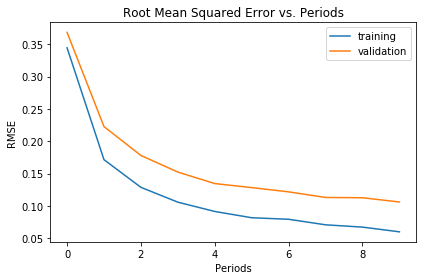

In [11]:
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0003),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 0.126
  period 01 : 0.108
  period 02 : 0.065
  period 03 : 0.059
  period 04 : 0.050
  period 05 : 0.047
  period 06 : 0.039
  period 07 : 0.040
  period 08 : 0.041
  period 09 : 0.036
Model training finished.
Final RMSE (on training data):   0.036
Final RMSE (on validation data): 0.048


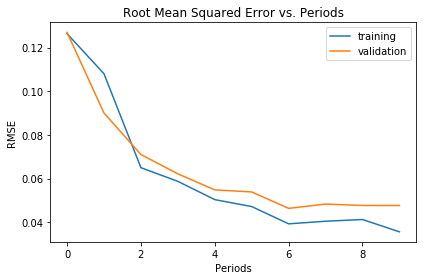

In [22]:
momentum_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.MomentumOptimizer(learning_rate=0.0003, momentum=0.99, use_nesterov=True),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [23]:
# Select regressor to use
regressor = momentum_regressor

In [24]:
# Compute stats on testing set
predict_testing_input_fn = lambda: input_fn(testing_examples, testing_targets, num_epochs=1, shuffle=False)
testing_predictions = regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item["predictions"][0] for item in testing_predictions])

print("Stats on testing data:")

testing_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(testing_targets, testing_predictions))
print("  RMSE  : %0.3f" % testing_root_mean_squared_error)

testing_mean_absolute_error = metrics.mean_absolute_error(testing_targets, testing_predictions)
print("  MAE   : %0.3f" % testing_mean_absolute_error)

testing_median_absolute_error = metrics.median_absolute_error(testing_targets, testing_predictions)
print("  MedAE : %0.3f" % testing_median_absolute_error)

testing_r2_score = metrics.r2_score(testing_targets, testing_predictions)
print("  R^2   : %0.3f" % testing_r2_score)

Stats on testing data:
  RMSE  : 0.158
  MAE   : 0.091
  MedAE : 0.082
  R^2   : 0.991


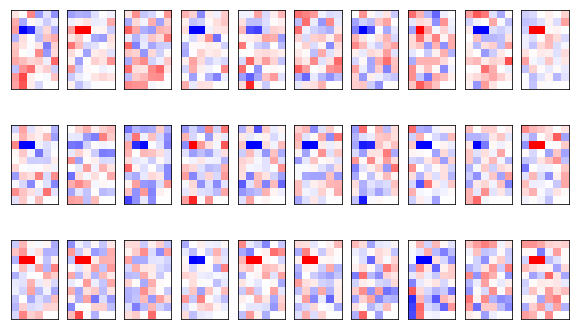

Index(['open', 'high', 'low', 'adjusted_close', 'volume', 'volume_adi',
       'volume_obv', 'volume_obvm', 'volume_cmf', 'volume_fi', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcli',
       'volatility_dch', 'volatility_dcl', 'volatility_dchi',
       'volatility_dcli', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'trend_adx_ind', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'momentum_rsi', 'momentum_mfi', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
    

In [25]:
# Visualize weights from first layer
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Pad with 0s at end to make length 60
    padded = np.pad(coef, (0, 60 - coef.size), "constant", constant_values=0)
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.bwr, vmin=-0.5, vmax=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

display.display(training_examples.columns)

In [26]:
selected_features = training_examples.columns.values
latest_df = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, selected_features)
latest_features = preprocess_features(latest_df, feature_means, feature_stds).head(prediction_period)
latest_targets = preprocess_targets(latest_df).head(prediction_period)

predict_latest_input_fn = lambda: input_fn(latest_features, latest_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_latest_input_fn)
predictions = pd.Series([item["predictions"][0] for item in predictions])
display.display(predictions)

predictions_df = pd.DataFrame()
predictions_df["days_into_future"] = -predictions.index + prediction_period
predictions_df["close"] = latest_df["adjusted_close"].head(prediction_period) * (predictions/100.0 + 1.0)

print("Current predictions:")
display.display(predictions_df)

0    0.131028
dtype: float64

Current predictions:


,days_into_future,close
0,1,1960.875926
